# Token-Wrapped Token Delta

## Ayodeji Adeniyi 13/08/2024
Personal research into efficiency of wrapped tokens, and their market impact,  and possible other uses (i.e., arbitrage oppurtunities, trading positions, and cross-chain liquidity and volume).

Interests include:

Analysis and predictions of price differences, liquidity, and volume of wrapped tokens compared to their native counterparts

Outlok on possible arbitrage opportunities, identifying improvemenmts to trading positions taken during the monitored period

Outlook on the potential for wrapped tokens to become the preferred trading instrument in the bct word and the impact on the market due to the increased cross-chain liquidity and volume

Interactive Plot Handling, and Python - Excel Dashboard curation


The research will be conducted using the following steps:
1.  Data Collection

    Price, Volume, Liquidity of tokens and wrapped versions of interest (BTC, ETH, USDT, USDC, SOL)

2.  Data Cleaning

    Remove missing values, duplicates, and outliers for time series split (prophet will handle these automatically)

    Compute the returns, volatility, and other metrics for the tokens and their wrapped versions

    Normalize the data to make it comparable

    Create features for machine learning models, such as moving averages, RSI, MACD, Bollinger Bands, and other technical indicators Display the data in a table for analysis

3.  Data Analysis

    Compare the price, volume, and liquidity of the tokens and their wrapped versions

    Conduct time series analysis to identify trends, seasonality, and cycles

    Conduct correlation analysis to identify relationships between the tokens and their wrapped versions

    Conduct regression analysis to identify the impact of the tokens on their wrapped versions

    Conduct sentiment analysis to identify the impact of news and events on the tokens and their wrapped versions

    Conduct ARIMA models on price, volume, and liquidity to predict future values

    Splite time series data into training and testing sets using time series split method, and monte carlo cross validation separately

    Train machine learning models on the training data to predict future values

    Evaluate the models using the testing data to identify the best model

4.  Data Visualization

    Create interactive charts and graphs to visualize the data using matplotlib, plotly and dash

5.  Conclusion

    Summarize the findings and provide recommendations based on the analysis

    Identify the limitations of the research and propose future work

    Provide the data, code, and results for reproducibility

The data will be collected from the following sources:
Coinbase and Kraken.  The data will be collected using the APIs provided by the exchanges.  The data will be collected in real-time and stored in a database for analysis.


https://api.pro.coinbase.com/products/SOL-USD/candles
https://api.pro.coinbase.com/products/MSOL-USD/candles


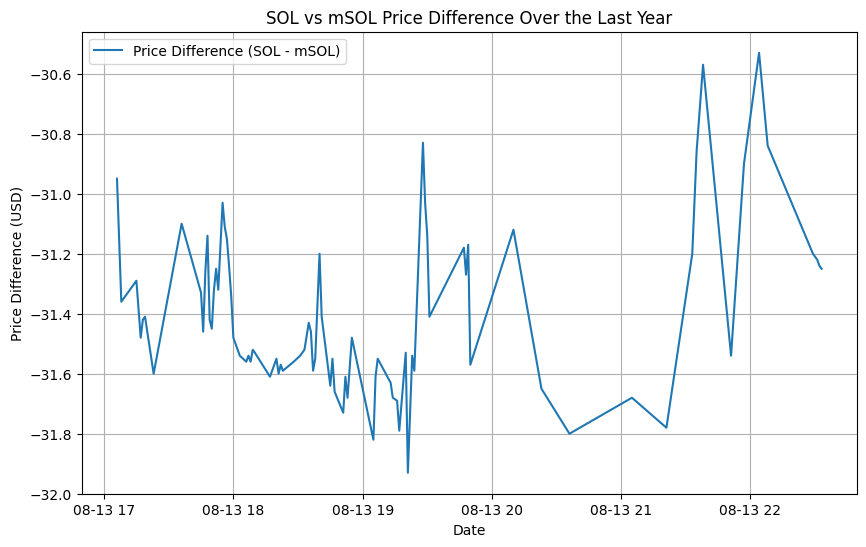

In [16]:
#   Solana vs mSOL Analysis

#   import libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta



#   load data

#   Kraken API endpoint
BASE_URLK = 'https://api.kraken.com'

#   Coinbase API endpoint
BASE_URLC = 'https://api.pro.coinbase.com'

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "CB-ACCESS-KEY": "MY_API_KEY"
}

#   Function to fetch historical data from APIS
def fetch_hist_data(product_id, start, end, interval, exchange):
    if exchange == 'kraken':
        url = f'{BASE_URLK}/0/public/OHLC?pair={product_id}&interval={interval}&since={start}'
    elif exchange == 'coinbase':
        url = f"{BASE_URLC}/products/{product_id}/candles"
        params = {
            "start": start,
            "end": end,
            "granularity": interval  # 311040000 for yearly candles
        }
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
    else:
        print('Invalid exchange')
        return None
    print(url)
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])

#   Define the time ranges (1 year)
end = datetime.utcnow()
start = end - timedelta(days=365)


# Price Difference

# Fetch the data for SOL-USD and MSOL-USD
sol_data = fetch_hist_data("SOL-USD", start.isoformat(), end.isoformat(), 311040000, 'coinbase')
msol_data = fetch_hist_data("MSOL-USD", start.isoformat(), end.isoformat(), 311040000, 'coinbase')

# Convert the 'time' column to datetime
sol_data['time'] = pd.to_datetime(sol_data['time'], unit='s')
msol_data['time'] = pd.to_datetime(msol_data['time'], unit='s')


# Calculate the difference in closing prices
data = pd.merge(sol_data[['time', 'close']], msol_data[['time', 'close']], on='time', suffixes=('_sol', '_msol'))
data['price_difference'] = data['close_sol'] - data['close_msol']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['price_difference'], label='Price Difference (SOL - mSOL)')
plt.title('SOL vs mSOL Price Difference Over the Last Year')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.grid(True)
plt.show()

